In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from forex_python.converter import CurrencyRates
from pandas_datareader.data import get_quote_yahoo

c = CurrencyRates()
%matplotlib inline

In [336]:
""" helper functions """

def get_tarif(amount):
    """ Added acquisition cost/tarif when buying/selling 
        
        In our case, the bank requires a minimum of 30€ per transaction, 
        but charges more as the amounts go up, although diminishingly so as the amount scales.
    """

    tarifs = {
        125000: 0.0025, 
        50000: 0.00375,
        0: 0.005
    }

    for threshold, tarif in tarifs.items():
        if abs(amount) >= threshold:
            return max(amount * tarif, 30) * -1
            break
                        
def get_stock_price(ticker):
    """ Returns the latest price of a stock """
    
    stock = get_quote_yahoo(ticker)
    return stock['price'].iloc[0]

(0, 261950.0)

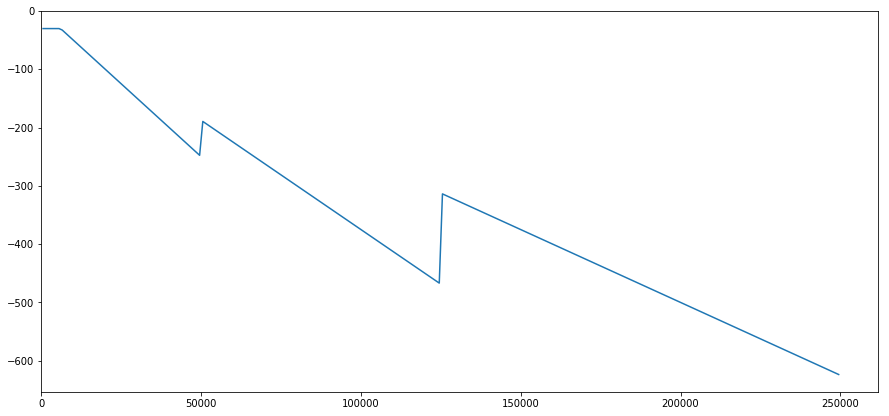

In [325]:
""" visualising the tarifs """

amounts = np.arange(500, 250000, 1000)
tarifs = np.array(list(map(get_tarif, amounts)))

f, ax = plt.subplots(1, figsize=(15,7))
ax.plot(amounts, tarifs)
ax.set_xlim(0)

In [335]:
# Reading our transaction history
thr = pd.read_csv('transaction_history.csv')

# Making sure the dataframe is chronologically ordered
thr = thr.sort_values(by='trade_date', ascending=True)
thr = thr.reset_index(drop=True)
thr.index += 1

# Forex_python's CurrencyRates.get_rate requires a datetime object
thr['trade_date'] = pd.to_datetime(thr['trade_date'], format='%d/%m/%Y')

# Fetch the fx rates
thr['fx_to_eur'] = thr.apply(lambda row: c.get_rate(row['currency'], 'EUR', row['trade_date']), axis=1)

# The metrics that matter for taxes:
thr['cash_eur'] = thr['quantity'] * thr['price'] * thr['fx_to_eur'] * -1

# Calculating tarifs and adding them to the cash movement
thr['tarif'] = thr.apply(lambda row: get_tarif(row['cash_eur']), axis=1)
thr['cash_eur'] += thr['tarif']

# Rearranging the columns
cols = [col for col in thr if col not in ['cash_eur', 'tarif']] + ['tarif', 'cash_eur']
thr = thr.reindex(columns=cols)
thr['fiscal_year'] = thr['trade_date'].dt.year

# printing our dataframe
thr = thr.round(2)
thr

ticker trade_date buy_sell  quantity   price currency  fx_to_eur  tarif  \
1    TSLA 2017-08-02      BUY        10  317.19      USD       0.85 -30.00   
2    TSLA 2017-11-02      BUY        10  300.00      USD       0.86 -30.00   
3    TSLA 2017-05-04      BUY         7  295.67      USD       0.92 -30.00   
4    TSLA 2019-03-06      BUY        20  278.50      USD       0.88 -30.00   
5     ALB 2017-11-08     SELL       -19  138.98      USD       0.86 -30.00   
6    TSLA 2018-10-09      BUY        19  258.50      USD       0.87 -30.00   
7    ASML 2017-11-09     SELL       -13  151.00      EUR       1.00 -30.00   
8    ASML 2017-03-12      BUY        13  116.55      EUR       1.00 -30.00   
9    TSLA 2016-12-14      BUY        13  200.60      USD       0.94 -30.00   
10   AAPL 2017-11-17      BUY        25  170.77      USD       0.85 -30.00   
11   AAPL 2019-01-18      BUY        40  157.00      USD       0.88 -30.00   
12   TSLA 2017-09-19     SELL       -13  376.57      USD       0.84 -30.00   
13    ALB 2017-03-24      BUY        19  105.54      USD       0.93 -30.00   
14   AAPL 2019-03-25     SELL       -40  188.00      USD       0.88 -33.20   
15   TSLA 2018-07-25      BUY        14  299.57      USD       0.86 -30.00   
16   AAPL 2017-02-28      BUY        20  136.98      USD       0.94 -30.00   
17   TSLA 2018-03-28      BUY        11  260.00      USD       0.81 -30.00   
18   AAPL 2018-05-29     SELL       -45  187.42      USD       0.87 -36.49   
19   TSLA 2017-09-29      BUY        14  343.77      USD       0.85 -30.00   

    cash_eur  fiscal_year  
1   -2711.52         2017  
2   -2606.10         2017  
3   -1924.18         2017  
4   -4957.22         2019  
5    2248.33         2017  
6   -4325.11         2018  
7    1933.00         2017  
8   -1545.15         2017  
9   -2480.03         2016  
10  -3649.47         2017  
11  -5537.56         2019  
12   4059.14         2017  
13  -1885.87         2017  
14   6606.96         2019  
15  -3617.53         2018  
16  -2615.36         2017  
17  -2336.88         2018  
18   7260.53         2018  
19  -4106.42         2017

In [283]:
""" Calculating total capital gains, irrespective of year.
    Takes into account transaction costs, but not holding fees.
"""

# Defining arguments for our Group By
aggs = {
    'trade_date': 'count',
    'quantity': 'sum',
    'tarif': 'sum',
    'cash_eur': 'sum'
}
cols = {
    'trade_date': 'transactions',
    'quantity': 'active_shares',
    'cash_eur': 'net_cash_eur'
}

# looking at the cumulative positions (realised capital gains/losses and current positions)
cap = thr.groupby(['ticker', 'currency']).agg(aggs).rename(columns=cols)

# Adding calculated columns
cap['stock_price'] = cap.apply(lambda row: get_stock_price(row.name[0]), axis=1)
cap['worth'] = cap['active_shares'] * cap['stock_price'] 
cap['current_fx_eur'] = cap.apply(lambda row: c.get_rate(row.name[1], 'EUR'), axis=1)
cap['worth_eur'] = cap['worth'] * cap['current_fx_eur']
cap['cap_gains_losses'] = cap['worth_eur'] + cap['net_cash_eur']

# Dropping those we don't need anymore
cap = cap.drop(['worth', 'current_fx_eur'], axis=1)

# Rounding values
cap = cap.round(2)

# print our dataframe
cap

transactions  active_shares   tarif  net_cash_eur  \
ticker currency                                                      
AAPL   USD                  5              0 -159.69       2065.10   
ALB    USD                  2              0  -60.00        362.46   
ASML   EUR                  2              0  -60.00        387.85   
TSLA   USD                 10            105 -300.00     -25005.85   

                 stock_price  worth_eur  cap_gains_losses  
ticker currency                                            
AAPL   USD            189.95       0.00           2065.10  
ALB    USD             81.98       0.00            362.46  
ASML   EUR            188.05       0.00            387.85  
TSLA   USD            279.86   26155.86           1150.01

In [ ]:
""" Calculating profit on each sale

    Strategy: 
        Maximizing capital gain profit per sale (not necessarily the
        best action if you're looking to minimize your tax bill).
    
    Approach:
        Run through timeline chronologically, adding positions to the portfolio state.
        When there is a sale:
            1) Isolate preceding buys of same ticker as sale
            2) Categorize:
                if > 6 months ago -> non-taxable
                if < 6 months ago -> = speculative income -> taxable
            3) in each category, sort by lowest purchasing price
            4) subtract sale units until 0, starting with > 6 months, lowest price
            5) update portfolio state so the next sale doesn't feed from wrong data
"""